# Step 2.4: Feature Importance
## Random Forest Feature Selection

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
FEATURES_PATH = BASE_PATH / 'data' / 'processed' / 'windowed_features'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'

In [2]:
# Load windowed features
wesad_df = pd.read_csv(FEATURES_PATH / 'WESAD_windowed_features.csv')
epm_df = pd.read_csv(FEATURES_PATH / 'EPM4_windowed_features.csv')
physionet_df = pd.read_csv(FEATURES_PATH / 'PhysioNet_windowed_features.csv')

print(f"WESAD: {len(wesad_df)} windows")
print(f"EPM-E4: {len(epm_df)} windows")
print(f"PhysioNet: {len(physionet_df)} windows")

WESAD: 1305 windows
EPM-E4: 2510 windows
PhysioNet: 6696 windows


In [3]:
# Combine datasets (exclude EPM-E4 for now as labels need refinement)
# Use WESAD and PhysioNet which have clear labels
combined_df = pd.concat([wesad_df, physionet_df], ignore_index=True)
print(f"Combined dataset: {len(combined_df)} windows")
print(f"\nLabel distribution:")
print(combined_df['label'].value_counts())

Combined dataset: 8001 windows

Label distribution:
label
Stress       3322
Aerobic      2143
Anaerobic    1620
Baseline      707
Amusement     209
Name: count, dtype: int64


In [4]:
# Identify feature columns (exclude metadata)
metadata_cols = ['subject_id', 'dataset', 'label', 'window_id', 'timestamp_start', 'timestamp_end']
feature_cols = [c for c in combined_df.columns if c not in metadata_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

Number of features: 40
Features: ['bvp_mean', 'bvp_std', 'bvp_min', 'bvp_max', 'bvp_range', 'hr_mean', 'hr_std', 'hrv_rmssd', 'hrv_sdnn', 'hrv_pnn50', 'hrv_lf_hf_ratio', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_range', 'eda_scr_count', 'eda_scr_amp_mean', 'eda_tonic_mean', 'eda_phasic_mean', 'eda_slope', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_range', 'temp_slope', 'acc_mag_mean', 'acc_mag_std', 'acc_mag_min', 'acc_mag_max', 'acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'acc_x_std', 'acc_y_std', 'acc_z_std', 'acc_sma', 'acc_energy', 'acc_entropy']


In [5]:
# Prepare data
X = combined_df[feature_cols].copy()
y = combined_df['label'].copy()

# Handle missing values
print(f"Missing values before: {X.isna().sum().sum()}")
X = X.fillna(X.median())
print(f"Missing values after: {X.isna().sum().sum()}")

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nClasses: {le.classes_}")

Missing values before: 8002
Missing values after: 8001

Classes: ['Aerobic' 'Amusement' 'Anaerobic' 'Baseline' 'Stress']


In [6]:
# Train Random Forest for feature importance
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Cross-validation score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y_encoded, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Fit on full data for feature importance
rf.fit(X, y_encoded)
print(f"Training accuracy: {rf.score(X, y_encoded):.4f}")

Cross-validation accuracy: 0.9165 (+/- 0.0066)
Training accuracy: 0.9979


In [7]:
# Extract feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Features by Importance:")
print(importance_df.head(20).to_string(index=False))

Top 20 Features by Importance:
        feature  importance
     acc_y_mean    0.128880
        acc_sma    0.077584
     acc_z_mean    0.055473
    acc_mag_std    0.046704
      acc_y_std    0.041105
     acc_x_mean    0.036729
       temp_min    0.032623
   acc_mag_mean    0.032293
      temp_mean    0.030753
     acc_energy    0.029544
       temp_max    0.028533
      acc_z_std    0.026264
eda_phasic_mean    0.024161
    acc_entropy    0.021777
       temp_std    0.021682
        eda_max    0.019918
      acc_x_std    0.019765
       eda_mean    0.019717
      eda_range    0.019458
     temp_range    0.019366


In [8]:
# Calculate percentiles and select features
importance_df['percentile'] = importance_df['importance'].rank(pct=True) * 100

# Select features above 50th percentile
threshold_percentile = 50
selected_features = importance_df[importance_df['percentile'] >= threshold_percentile]['feature'].tolist()

print(f"\nSelected features (>= {threshold_percentile}th percentile): {len(selected_features)}")
print(selected_features)


Selected features (>= 50th percentile): 21
['acc_y_mean', 'acc_sma', 'acc_z_mean', 'acc_mag_std', 'acc_y_std', 'acc_x_mean', 'temp_min', 'acc_mag_mean', 'temp_mean', 'acc_energy', 'temp_max', 'acc_z_std', 'eda_phasic_mean', 'acc_entropy', 'temp_std', 'eda_max', 'acc_x_std', 'eda_mean', 'eda_range', 'temp_range', 'bvp_std']


In [9]:
# Categorize features by signal type
def categorize_feature(feat):
    if feat.startswith('bvp') or feat.startswith('hr'):
        return 'BVP/HR'
    elif feat.startswith('eda'):
        return 'EDA'
    elif feat.startswith('temp'):
        return 'TEMP'
    elif feat.startswith('acc'):
        return 'ACC'
    return 'Other'

importance_df['signal_type'] = importance_df['feature'].apply(categorize_feature)

print("\nFeature importance by signal type:")
signal_importance = importance_df.groupby('signal_type')['importance'].agg(['sum', 'mean', 'count'])
signal_importance = signal_importance.sort_values('sum', ascending=False)
print(signal_importance)


Feature importance by signal type:
                  sum      mean  count
signal_type                           
ACC          0.546378  0.042029     13
EDA          0.176705  0.017671     10
TEMP         0.143579  0.023930      6
BVP/HR       0.133337  0.012122     11


In [10]:
# Validate with selected features only
X_selected = X[selected_features]

rf_selected = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

cv_scores_selected = cross_val_score(rf_selected, X_selected, y_encoded, cv=cv, scoring='accuracy')
print(f"CV accuracy with all features: {cv_scores.mean():.4f}")
print(f"CV accuracy with selected features: {cv_scores_selected.mean():.4f}")
print(f"Difference: {(cv_scores_selected.mean() - cv_scores.mean())*100:.2f}%")

CV accuracy with all features: 0.9165
CV accuracy with selected features: 0.9145
Difference: -0.20%


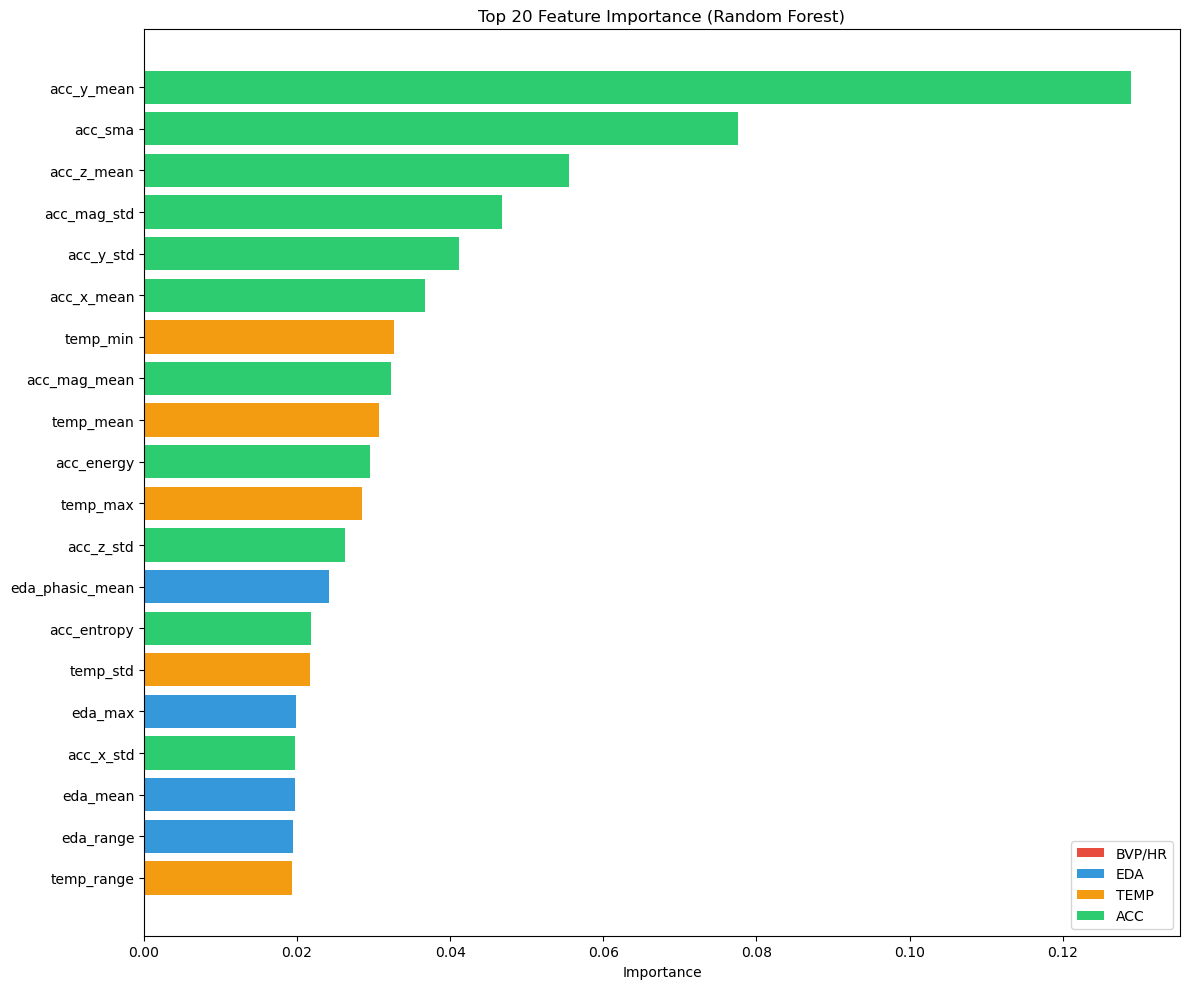

Saved: /home/alvaro-ibarra/smartwatch-stress-detection/outputs/figures/feature_importance_rf.png


In [11]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 10))

top_20 = importance_df.head(20)
colors = {'BVP/HR': '#e74c3c', 'EDA': '#3498db', 'TEMP': '#f39c12', 'ACC': '#2ecc71'}
bar_colors = [colors.get(t, '#95a5a6') for t in top_20['signal_type']]

bars = ax.barh(range(len(top_20)), top_20['importance'], color=bar_colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance (Random Forest)')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_PATH / 'feature_importance_rf.png'}")

In [12]:
# Save outputs
importance_df.to_csv(OUTPUT_PATH / 'feature_importance_scores.csv', index=False)

with open(OUTPUT_PATH / 'selected_features.txt', 'w') as f:
    f.write(f"Selected features (>= {threshold_percentile}th percentile)\n")
    f.write(f"Total: {len(selected_features)}\n\n")
    for feat in selected_features:
        f.write(f"{feat}\n")

# RF performance metrics
rf_metrics = {
    'model': 'RandomForest',
    'n_features_all': len(feature_cols),
    'n_features_selected': len(selected_features),
    'cv_accuracy_all': cv_scores.mean(),
    'cv_accuracy_std_all': cv_scores.std(),
    'cv_accuracy_selected': cv_scores_selected.mean(),
    'cv_accuracy_std_selected': cv_scores_selected.std(),
    'threshold_percentile': threshold_percentile
}
pd.DataFrame([rf_metrics]).to_csv(OUTPUT_PATH / 'rf_feature_selection_metrics.csv', index=False)

print("Saved:")
print("  - feature_importance_scores.csv")
print("  - selected_features.txt")
print("  - rf_feature_selection_metrics.csv")

Saved:
  - feature_importance_scores.csv
  - selected_features.txt
  - rf_feature_selection_metrics.csv


In [13]:
# Summary
print("="*60)
print("STEP 2.4 COMPLETE: Feature Importance")
print("="*60)
print(f"\nRandom Forest Performance:")
print(f"  CV Accuracy (all {len(feature_cols)} features): {cv_scores.mean():.4f}")
print(f"  CV Accuracy ({len(selected_features)} selected): {cv_scores_selected.mean():.4f}")
print(f"\nTop 5 Features:")
for i, row in importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f} ({row['signal_type']})")
print(f"\nSignal Type Contribution:")
for sig, row in signal_importance.iterrows():
    print(f"  {sig}: {row['sum']:.4f} ({int(row['count'])} features)")
print("="*60)

STEP 2.4 COMPLETE: Feature Importance

Random Forest Performance:
  CV Accuracy (all 40 features): 0.9165
  CV Accuracy (21 selected): 0.9145

Top 5 Features:
  acc_y_mean: 0.1289 (ACC)
  acc_sma: 0.0776 (ACC)
  acc_z_mean: 0.0555 (ACC)
  acc_mag_std: 0.0467 (ACC)
  acc_y_std: 0.0411 (ACC)

Signal Type Contribution:
  ACC: 0.5464 (13 features)
  EDA: 0.1767 (10 features)
  TEMP: 0.1436 (6 features)
  BVP/HR: 0.1333 (11 features)
